# What drives the price of a car?

![](https://github.com/ashrivastav33/predict_car_price/blob/main/images/kurt.jpeg?raw=1)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

# Our goal is to utilize historical data on car sales and associated car features (year, color, make, etc.) in order to identify underlying relationship between features and the resulting sale price. Car price in this case is the dependent variable (y) while the set of feature characteristics of specific cars is a matrix of independent variables (X). The modelled relationship will be used to forecast potential sale price of new cars based on known combination of their features.

In [1]:
#Importing as required libraries

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [2]:
#Reading the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/ashrivastav33/predict_car_price/refs/heads/main/data/vehicles.csv'
used_vehicle_df = pd.read_csv(url)

In [3]:
#Validating data is loaded correctly in the used_vehicle_df dataframe
used_vehicle_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
#Validating data is loaded correctly in the used_vehicle_df dataframe
used_vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [5]:
#Exploring statistical details for used_vehicle_df dataframe
used_vehicle_df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [6]:
# It seems like there are some outliers and null values in the price and odometer columns likely a result of manual mistyping
used_vehicle_df.sort_values('odometer', ascending = False).head(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
320410,7306325854,medford-ashland,1,1950.0,dodge,5 window,fair,NaN,gas,10000000.0,clean,manual,NaN,NaN,NaN,NaN,NaN,or
110623,7306067318,sarasota-bradenton,450,2000.0,ford,f-150,NaN,NaN,gas,10000000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl
103798,7303067734,ocala,6500,1978.0,NaN,1978 van,good,8 cylinders,gas,10000000.0,clean,automatic,E27HHBD1806,rwd,NaN,truck,NaN,fl
108102,7316668762,sarasota-bradenton,450,2000.0,ford,f-150,NaN,NaN,gas,10000000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl
105059,7315237611,orlando,500,2010.0,chevrolet,colorado,NaN,NaN,gas,10000000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,fl


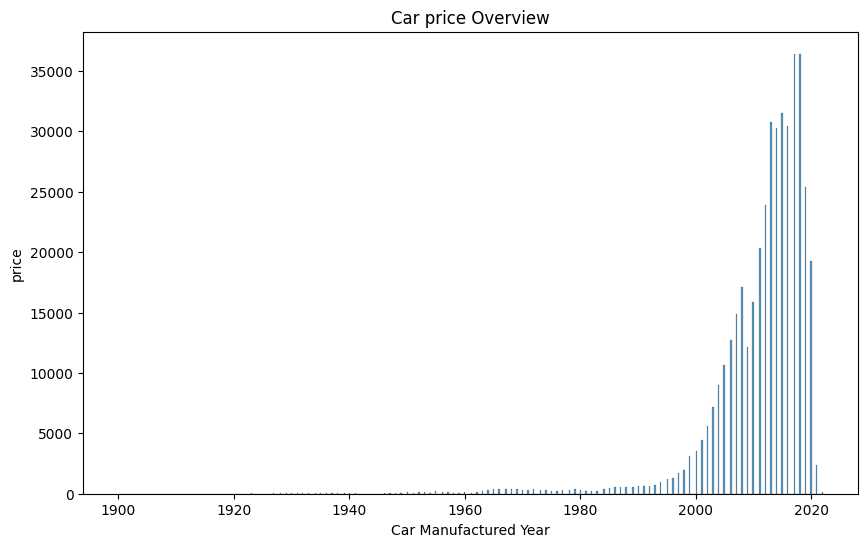

In [7]:
# Use a histogram to visualize the Car pricing vs year
plt.figure(figsize=(10, 6))
sns.histplot(data=used_vehicle_df, x='year')
plt.title('Car price Overview')
plt.xlabel('Car Manufactured Year')
plt.ylabel('price')
plt.show()

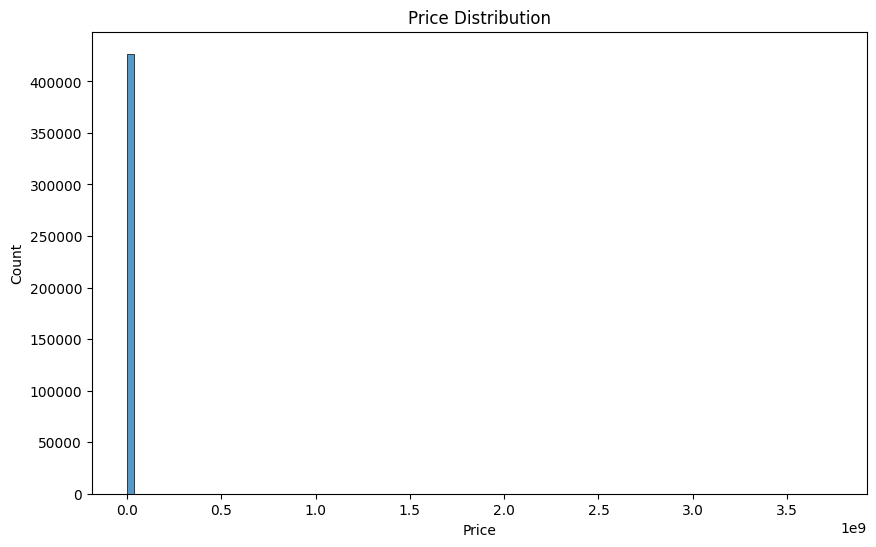

In [8]:
#Visual to showcase Price Distribution
plt.figure(figsize=(10,6))
sns.histplot(used_vehicle_df['price'], bins=100)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.show()

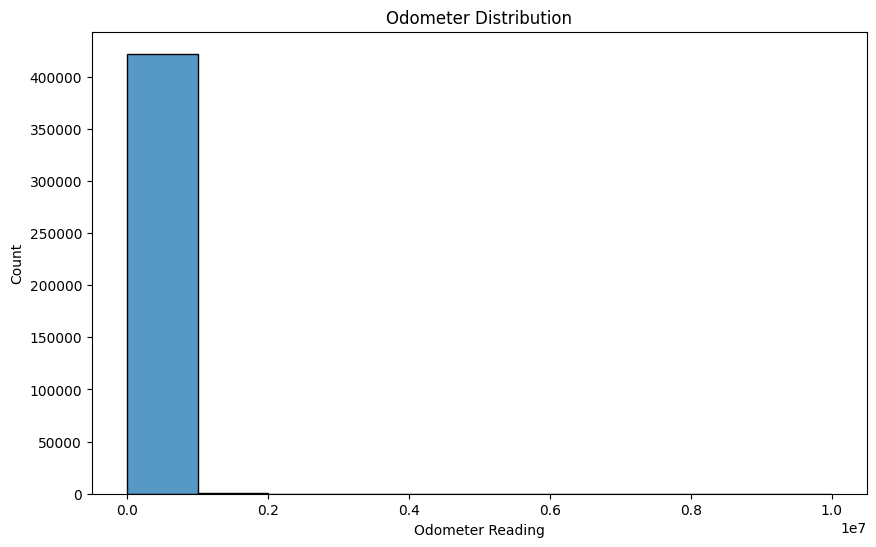

In [9]:
#Visual to showcase Odometer Distribution
plt.figure(figsize=(10,6))
sns.histplot(used_vehicle_df['odometer'], bins=10)
plt.title("Odometer Distribution")
plt.xlabel("Odometer Reading")
plt.show()

**Analysis so far**, based on the visual above we can state that car price is usually higher for car manufactured in last 10 to 15 years

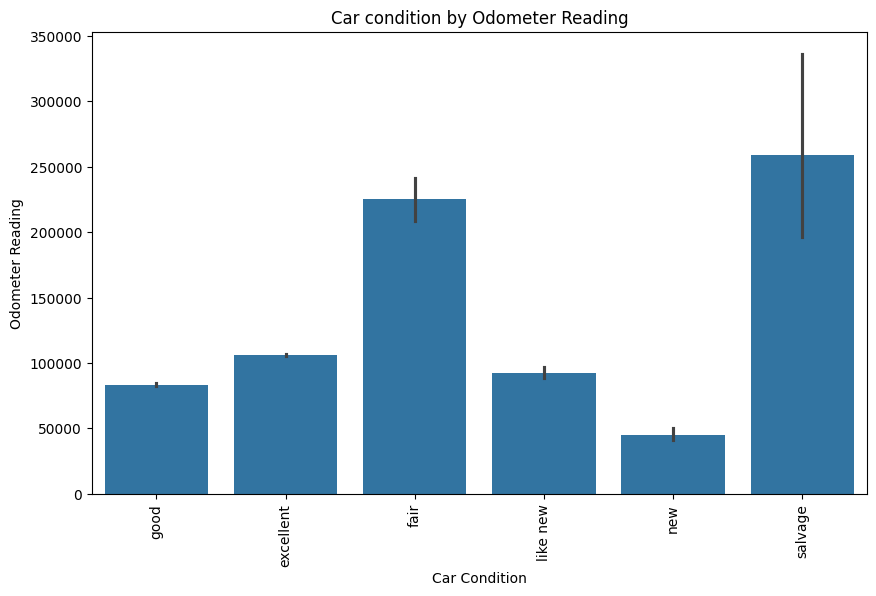

In [10]:
#Creating Bar plots using seaborn library had to rotate labels at 90 degree as it was looking not good in default setting
plt.figure(figsize=(10, 6))
sns.barplot(x='condition', y='odometer', data=used_vehicle_df)
plt.title('Car condition by Odometer Reading')
plt.xlabel('Car Condition')
plt.xticks(rotation=90)
plt.ylabel('Odometer Reading')
plt.show()

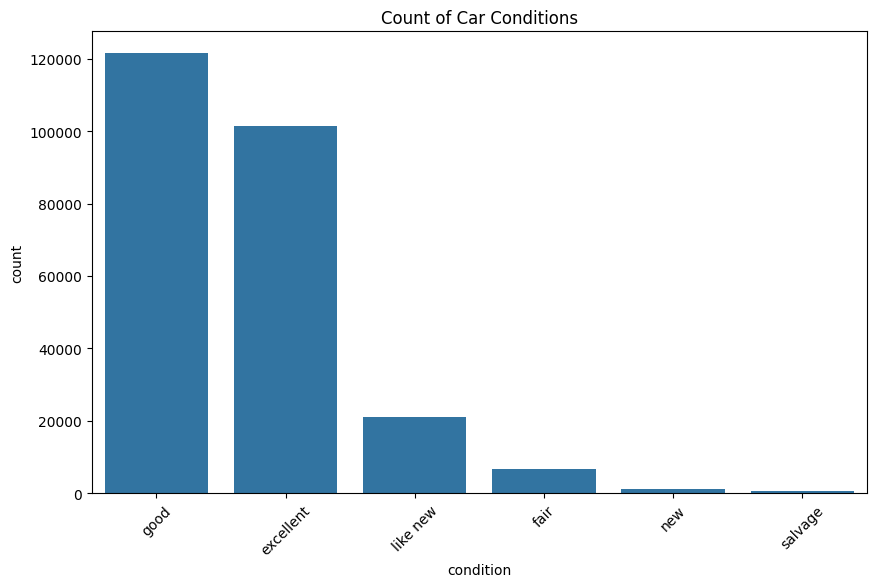

In [11]:
#Creating Bar plots using seaborn library had to rotate labels at 45 degree as it was looking not good in deafult setting
plt.figure(figsize=(10,6))
sns.countplot(data=used_vehicle_df, x='condition', order=used_vehicle_df['condition'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Count of Car Conditions")
plt.show()

**Analysis so far**, based on the visual above we can state that ~40-50% of the cars are in Good and Excellent condition

In [12]:
# With size being a column with most NaNs, let's explore whether some types just don't have an associated size in the data
used_vehicle_df.query('~size.isnull() and ~type.isnull()')['type'].unique()

array(['truck', 'SUV', 'pickup', 'mini-van', 'sedan', 'offroad', 'bus',
       'van', 'convertible', 'coupe', 'hatchback', 'wagon', 'other'],
      dtype=object)

In [13]:
used_vehicle_df.query('size.isnull() and ~type.isnull()')['type'].unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback', 'sedan',
       'convertible', 'wagon', 'van', 'bus', 'mini-van', 'offroad'],
      dtype=object)

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

Overall, some columns have only few NaN values which we'd be fine dropping, however, others (such as 'size', 'type' or 'cyllinders') have quite a few, dropping them would leave us with less than 50% of the initial sample. Let's explore the dataset further to see potential relationships between NaNs across columns

In [14]:
# Looking for missing values
print(used_vehicle_df.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


**Analysis so far** Based on above finding it seems size has ~90% missing records, as in one of the office hours it was mentioned if we have less than 20% missing data we should try to clean it if possible else we should remove that entry to make more meaning data exploration, hence I am planning to remove car column after exploring its unique value

In [15]:
columns_to_drop = ['price','year','manufacturer','model','condition','cylinders','fuel','odometer','title_status','transmission','drive', 'type', 'paint_color', 'state']

In [16]:
used_vehicle_df = used_vehicle_df.dropna(subset = columns_to_drop)
used_vehicle_df = used_vehicle_df.drop(['id','VIN'], axis = 1)
used_vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115988 entries, 31 to 426878
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        115988 non-null  object 
 1   price         115988 non-null  int64  
 2   year          115988 non-null  float64
 3   manufacturer  115988 non-null  object 
 4   model         115988 non-null  object 
 5   condition     115988 non-null  object 
 6   cylinders     115988 non-null  object 
 7   fuel          115988 non-null  object 
 8   odometer      115988 non-null  float64
 9   title_status  115988 non-null  object 
 10  transmission  115988 non-null  object 
 11  drive         115988 non-null  object 
 12  size          79195 non-null   object 
 13  type          115988 non-null  object 
 14  paint_color   115988 non-null  object 
 15  state         115988 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 15.0+ MB


In [17]:
# Checking unique Size values

print(used_vehicle_df['size'].unique())

# We are left with ~ a third of a dataset with most values present, let's replace 'size' NaN with 'unknown' value
#used_vehicle_df.fillna('unknown', inplace = True)

['full-size' nan 'mid-size' 'compact' 'sub-compact']


In [18]:
# Working to remove outliers based on price and odometer columns based on the +/- 2 std rule and 0 for price, as outlier can cause model to misinterpret
price_upper = used_vehicle_df['price'].median() + 2*used_vehicle_df['price'].std()
price_lower = used_vehicle_df['price'].median() - 2*used_vehicle_df['price'].std()
odometer_upper = used_vehicle_df['odometer'].median() + 2*used_vehicle_df['odometer'].std()
odometer_lower = used_vehicle_df['odometer'].median() - 2*used_vehicle_df['odometer'].std()
#print(price_upper, price_lower, odometer_upper, odometer_lower)

#Removing extremely expensive/cheap cars, highest odometer value
used_vehicle_df = used_vehicle_df.query('price > @price_lower and price < @price_upper and price < 1000000 and odometer > @odometer_lower and odometer < @odometer_upper and price > 1')

In [19]:
#Feature Engineering
#Let's also replace column year with age counted from current year
used_vehicle_df['age'] = 2025 - used_vehicle_df['year']
print(used_vehicle_df['age'].describe())
#Year doesn't really matter what matters is age of the car as of 2025
used_vehicle_df = used_vehicle_df.drop('year', axis = 1)

count    110526.000000
mean         15.563071
std           9.559975
min           3.000000
25%          10.000000
50%          13.000000
75%          19.000000
max         125.000000
Name: age, dtype: float64


In [20]:
#Separate the dataset into features (X) by dropping the target column 'price'

X = used_vehicle_df.drop('price', axis = 1)

#Define the target variable (y) as the natural log of price

y = np.log(used_vehicle_df['price'])

# Spliting the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 32)

In [21]:
#Sort Price column in the dataframe

used_vehicle_df['price'].sort_values(ascending = True)

,price
380551,3
297060,3
102428,4
261436,4
102494,4
...,...
123206,155000
323687,155000
113503,165000
104511,169999


In [39]:
#Creating Pipeline of numerical features
numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
     ('scaler', StandardScaler())
])

#Find numeric columns

numeric_features = list(X_train.select_dtypes('float64').columns)

#Find categorical columns

categorical_features = list(X_train.select_dtypes('object').columns)

# Creating pipeline for categorical features

categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

full_transformer = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
     ('cat', categorical_transformer, categorical_features)
     ])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [27]:
#Build Ridge Pipeline to run the Ridge regression model and run grid search, tra
ridge_pipe_mod = Pipeline([
    ('transform', full_transformer ),
     ('linreg', Ridge())
     ])

#Apply Hyperparams to grid search
param_dict = {
    'linreg__alpha' : [0.1,1,10,100],
    'transform__num__poly__degree' : [1,2,3]
    }

#Train the model
grid = GridSearchCV(estimator = ridge_pipe_mod, param_grid = param_dict)

#Fit the model
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['odometer',
                                                                          'age']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['region',
                                                                          'manufacturer',
                                                                          'model',
                                                                          'condition',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'title_status',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state'])])),
                                       ('linreg', Ridge())]),
             param_grid={'linreg__alpha': [0.1, 1, 10, 100],
                         'transform__num__poly__degree': [1, 2, 3]})

**Analysis so far,** I noticied that training the model does take time based on your dataset, the value add of using grid search is that you can build ur hyperparameter and pass value to find the best combination of the model, need to read more if it can lead to overfitting

In [28]:
#Getting which Hyperparamter suits best to the model
grid.best_params_

{'linreg__alpha': 1, 'transform__num__poly__degree': 3}

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [29]:
#Using test set on the model found by grid search
y_hat_test = grid.best_estimator_.predict(X_test)

# Calculate the Mean Absolute Error (MAE) on the test set
test_mae = mean_absolute_error(np.exp(y_test), np.exp(y_hat_test))

# Calculate the mean actual price in the test set
mean_y_test = np.exp(y_test).mean()

print(test_mae/mean_y_test)

0.19870984957447219


In [37]:
#Using permutation importance to find importance of features in the dataset
r = permutation_importance(grid.best_estimator_, X_test, y_test)
valueable_columns = pd.concat([pd.DataFrame(X_test.columns), pd.DataFrame(r['importances_mean'])], axis = 1)
valueable_columns.columns = ['variable', 'importance_mean']


In [38]:
# Creating a bar chart showing feature importance, sorted from least to most important
fig = px.bar(valueable_columns.sort_values('importance_mean',ascending=True),
             x = 'importance_mean',
             y = 'variable',
             title = 'Factors with most influence on price (mean importance)')
fig.show()

**Analsis so far,** as we can clearly see the age of the car decides the price of the car followed by model, odometer & manufacterer

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [45]:
#Creating a PolynomialFeatures generator with degree 3
n = PolynomialFeatures(degree=3, include_bias=False)

#Fitting the polynomial transformer
n_fit = n.fit(X_test[numeric_features])

#Finding the names of all polynomial-generated numeric features
numeric_names = n_fit.get_feature_names_out(numeric_features)


#Creating a OneHotEncoder
c = OneHotEncoder()

#Fitting the encoder
c_fit = c.fit(X_train[categorical_features])

#Finding the names of all polynomial-generated categorical features.
cat_names = c_fit.get_feature_names_out(categorical_features)


#Combining both features
all_variables = list(numeric_names) + list(cat_names)


#Creating DataFrame with feature name & the coefficient learned by our Ridge regression model.
coefficients = pd.concat(
    [pd.DataFrame(all_variables),
     pd.DataFrame(grid.best_estimator_.named_steps['linreg'].coef_)],
    axis=1
)

coefficients.columns = ['feature', 'coefficient']


#Getting the 20 most negative coefficients
coefficients.sort_values('coefficient', ascending=True).head(20)


,feature,coefficient
1231,model_4runner sr5 sport awd,-4.767591
4541,model_f-250 super duty ext-cab,-4.307765
4558,model_f-250 xlt lariat,-3.502814
8459,model_sierra xlt crew,-3.456779
7786,model_ridgeline 4wd,-3.389607
5635,model_grand cherokee altitude,-3.370988
2938,model_civic turbo ex-l,-3.267272
7838,model_roadster 2000,-3.228233
10372,model_z28,-3.203872
4812,model_f250 ext cab 4x4,-3.098260


In [46]:

#getting the 20 largest positive coefficients
coefficients.sort_values('coefficient', ascending=True).tail(20)


,feature,coefficient
2362,model_bus camper,1.160529
9885,model_viper,1.181588
2203,model_benz g500,1.187171
9795,model_vanagon syncro,1.210286
3581,model_delica reimo,1.242352
2563,model_camper,1.247088
4204,model_eurovan weekender,1.251510
10244,model_xk150 se dhc,1.277225
9792,model_vanagon,1.298112
3244,model_corvette zr1,1.309057


In [44]:
top_neg = coefficients.sort_values('coefficient').head(20)

# Get top 20 features that increase price (most positive coefficients)
top_pos = coefficients.sort_values('coefficient', ascending=False).head(20)

# Combine them for a single chart
top_features = pd.concat([top_neg, top_pos])

# Create horizontal bar chart for top features
fig = px.bar(
    top_features,
    x='coefficient',
    y='feature',
    orientation='h',
    title='Top Features Influencing Car Price (Positive & Negative)',
    height=800
)

fig.show()

## **Conclusion**

After analyzing data from over 400,000 used vehicle sales, the team developed a linear regression model to predict sale prices based on various vehicle characteristics, including model, condition, and age, achieving an average accuracy of approximately ±20%. Beyond providing recommended listing prices for new vehicles, the model’s greatest value lies in its ability to quantify the impact of specific features on price, helping inform decisions when evaluating potential inventory.

Among all the characteristics analyzed, a vehicle’s age has the most significant influence on its value. However, the relationship is not strictly linear, so there isn’t a simple formula to deduct a fixed amount per year. In general, older vehicles tend to have a stronger negative impact on price compared to newer ones

### **Used Vehicle Price Analysis | Findings | Learnings**

*   Data: 400,000+ used vehicle sales analyzed.
*   Model: Linear regression predicts price from features like age, model, condition, manufacturer, and color.


*   Accuracy: Average prediction error of ~20%.

Key Insights:

*    Age: Biggest factor; older cars lower price more.
*    Model & Manufacturer: Certain models (e.g., Skyline GTR 32) and brands (e.g., Ferrari) increase value; others reduce it.
*   Condition: Excellent / Like New boosts price; Salvage / Fair reduces it.
*    Color: Small effect; some colors slightly increase/decrease value.

Recommendations:

*   Use insights to price cars competitively.
*   Focus on features that impact price most when buying inventory.
*   Improve data quality for better future predictions.